# Imports and data loading

In [1]:
import csv
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

import scanorama
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

set_seed(123)

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=False

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
N_PCS_SCAN = 100
N_PCS_SEURAT = 30

In [3]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

In [4]:
anndataset_10k = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_5k = anndata.read(save_path + "pbmc_5k_protein_v3.h5ad")

In [5]:
mutual_names = anndataset_10k.var_names.intersection(anndataset_5k.var_names)
anndataset_10k = anndataset_10k[:, mutual_names]
anndataset_5k = anndataset_5k[:, mutual_names]

adata_total = anndata.AnnData.concatenate(anndataset_10k, anndataset_5k)
seurat_v3_highly_variable_genes(adata_total, n_top_genes=4000)
global_high_var_genes = adata_total.var.index[adata_total.var["highly_variable"]]

(15792,)
(6855, 15792)
(15792,)
(3994, 15792)


In [6]:
dataset_10k = AnnDatasetFromAnnData(ad=anndataset_10k[:, global_high_var_genes])
protein_data_10k = CellMeasurement(
    name="protein_expression",
    data=anndataset_10k.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_10k.uns["protein_names"],
)
dataset_10k.initialize_cell_measurement(protein_data_10k)

dataset_5k = AnnDatasetFromAnnData(ad=anndataset_5k[:, global_high_var_genes])
protein_data_5k = CellMeasurement(
    name="protein_expression",
    data=anndataset_5k.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_5k.uns["protein_names"],
)
dataset_5k.initialize_cell_measurement(protein_data_5k)

[2020-04-25 11:38:38,761] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-25 11:38:38,763] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-25 11:38:38,809] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-25 11:38:38,855] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-04-25 11:38:38,980] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-25 11:38:38,982] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-25 11:38:39,010] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-25 11:38:39,038] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


In [7]:
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_10k, dataset_5k])

[2020-04-25 11:38:39,090] INFO - scvi.dataset.dataset | Keeping 4000 genes
[2020-04-25 11:38:39,167] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-25 11:38:39,254] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-25 11:38:39,256] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-25 11:38:39,300] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-25 11:38:39,347] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-25 11:38:39,349] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-25 11:38:39,595] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-25 11:38:39,597] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-25 11:38:39,599] INFO - scvi.dataset.dataset | Keeping 14 columns in protein_expression


In [8]:
full_data = dataset.X
norm_full_data = anndata.AnnData(X=full_data)
sc.pp.normalize_per_cell(norm_full_data, counts_per_cell_after=1e4)
sc.pp.log1p(norm_full_data)
norm_full_data = anndata.AnnData(
    X=np.concatenate(
        [
            norm_full_data.X,
            np.log1p(dataset.protein_expression),
        ],
        axis=1,
    )
)
col_names = np.concatenate([dataset.gene_names, dataset.protein_names])
norm_full_data.var_names = col_names

In [9]:
datasets = [dataset_10k, dataset_5k, dataset]
models = []
trainers = []
names = ["pbmc_10k_harmo", "pbmc_5k_harmo", "pbmc15k_harmo"]

for d in datasets:
    if d.n_batches > 1:
        m = TOTALVI(d.nb_genes, d.protein_expression.shape[1], n_latent=20, n_batch=d.n_batches, encoder_batch=True)
    else:
        m = TOTALVI(d.nb_genes, d.protein_expression.shape[1], n_latent=20)
    models.append(m)
    use_cuda = True
    lr = 4e-3
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 45,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }

    trainer = TotalTrainer(
        m,
        d,
        train_size=0.90,
        test_size=0.10,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory":False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainers.append(trainer)
totalvae_10k, totalvae_5k, totalvae = models[0], models[1], models[2]

In [10]:
if overwrite is True:
    for t, n in zip(trainers, names):
        t.train(lr=lr, n_epochs=500)
        torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")
else:
    for m, n, t in zip(models, names, trainers):
        try:
            m.load_state_dict(torch.load("saved_models/" + n + ".pt"))
            m.eval()
        except FileNotFoundError:
            t.train(lr=lr, n_epochs=500)
            torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")

In [11]:
# create posterior on full data
posteriors = []
latents = []
for t, m, d in zip(trainers, models, datasets):
    full_posterior = t.create_posterior(
        m, d, indices=np.arange(len(d)), type_class=TotalPosterior
    )
    posteriors.append(full_posterior)
    # extract latent space
    latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()
    latents.append(latent_mean)

In [12]:
post_adatas = []
if overwrite:
    for n in names:
        os.remove("saved_post_adata/" + n + ".h5ad")
for n in names:
    try:
            post_adatas.append(anndata.read_h5ad("saved_post_adata/" + n + ".h5ad"))
    except OSError:
        for d, l, n in zip(datasets, latents, names):
            post_adata = anndata.AnnData(X=d.X)
            post_adata.var.index = d.gene_names
            post_adata.obsm["X_totalVI"] = l
            sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
            sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.8)
            sc.tl.umap(post_adata, min_dist=0.3)
            post_adata.write("saved_post_adata/" + n + ".h5ad", compression="gzip")
            post_adatas.append(post_adata)
post_adatas[2].obs["batch_indices"] = [str(b[0]) for b in datasets[2].batch_indices]

In [13]:
d_names = ["PBMC_10k", "PBMC_5k"]
post_adatas[2].obs["batch_indices"] = [d_names[b[0]] for b in datasets[2].batch_indices]

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


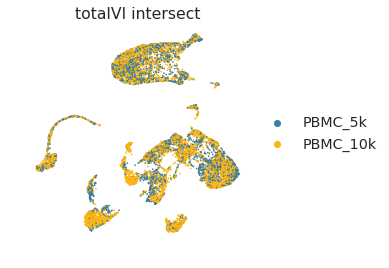

In [14]:
perm_inds = np.random.permutation(len(post_adatas[2]))
fig = sc.pl.umap(
    post_adatas[2][perm_inds], 
    color=["batch_indices"],
    title="totalVI intersect",
    return_fig=True,
    frameon=False
)
plt.savefig("figures/pbmc_umap_intersection.pdf", dpi=DPI, bbox_inches="tight")

In [15]:
ENTROPY_K = 100
harmo_metrics = pd.DataFrame(
    index=["totalVI-intersect", "totalVI-union", "scanorama", "Seurat v3"],
    columns=["Mixing metric", "Hotspot metric"],
)
harmo_metrics["models"] = [
    "totalVI-intersect",
    "totalVI-union",
    "scanorama",
    "Seurat v3",
]

# knn = np.ceil(len(dataset.X) * (np.arange(0.1, 1, 0.1)) / 100).astype(int)


In [16]:
harmo_metrics.loc["totalVI-intersect", "Mixing metric"] = entropy_batch_mixing(
    post_adatas[2].obsm["X_totalVI"], datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.36814452944971887


In [17]:
harmo_metrics.loc["totalVI-intersect", "Hotspot metric"], _, _ = hotspot_score(
    norm_full_data,
    post_adatas[0].obsm["X_totalVI"],
    post_adatas[1].obsm["X_totalVI"],
    post_adatas[2].obsm["X_totalVI"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4014/4014 [00:01<00:00, 2577.23it/s]


8.165667560368941
27.144894189642976


In [18]:
_, hs1, hs2 = hotspot_score(
    norm_full_data,
    post_adatas[0].obsm["X_totalVI"],
    post_adatas[1].obsm["X_totalVI"],
    post_adatas[2].obsm["X_totalVI"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4014/4014 [00:01<00:00, 2787.20it/s]


8.165667560368941
27.144894189642976


## Scanorama

In [19]:
b = datasets[2].batch_indices.ravel()

# RNA is standard log normalized, protein just log transform
# Columns are standard scaled after
full_data = datasets[2].X
scan_adata = norm_full_data.copy()
sc.pp.scale(scan_adata)
col_names = np.concatenate([datasets[2].gene_names, datasets[2].protein_names])
scan_adata.X = normalize(scan_adata.X)
integrated, corrected, genes = scanorama.correct(
    [scan_adata.X[b == 0], scan_adata.X[b == 1]],
    [col_names, col_names],
    return_dimred=True,
)
integrated_cat = np.concatenate(integrated, axis=0)

Found 4014 genes among all datasets
[[0.         0.82774161]
 [0.         0.        ]]
Processing datasets (0, 1)


In [20]:
scan_adata.obsm["X_scan"] = integrated_cat
scan_adata.obs["Scanorama"] = [d_names[int(b)] for b in datasets[2].batch_indices]
sc.pp.neighbors(scan_adata, use_rep="X_scan", n_neighbors=20)
sc.tl.umap(scan_adata, min_dist=0.6)
sc.tl.leiden(scan_adata, key_added="leiden_scan", resolution=0.8)

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "

In [21]:
harmo_metrics.loc["scanorama", "Mixing metric"] = entropy_batch_mixing(
    integrated_cat, datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.36814452944971887


In [22]:
b = datasets[2].batch_indices.ravel()

scan_batch_0 = anndata.AnnData(norm_full_data.X[b == 0].copy())
sc.pp.scale(scan_batch_0)
scan_batch_0.X = normalize(scan_batch_0.X)
sc.tl.pca(scan_batch_0, n_comps=N_PCS_SCAN)

scan_batch_1 = anndata.AnnData(norm_full_data.X[b == 1].copy())
sc.pp.scale(scan_batch_1)
scan_batch_1.X = normalize(scan_batch_1.X)
sc.tl.pca(scan_batch_1, n_comps=N_PCS_SCAN)

In [23]:
harmo_metrics.loc["scanorama", "Hotspot metric"], hs_joint_1_results, hs_1_results = hotspot_score(
    norm_full_data,
    scan_batch_0.obsm["X_pca"],
    scan_batch_1.obsm["X_pca"],
    scan_adata.obsm["X_scan"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4014/4014 [00:01<00:00, 2458.32it/s]


30.407190814160046
14.098511323862976


Trying to set attribute `.obs` of view, making a copy.
... storing 'Scanorama' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


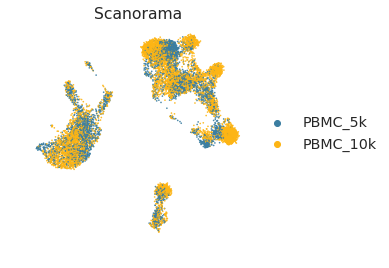

In [24]:
inds = np.random.permutation(np.arange(scan_adata.X.shape[0]))
fig = sc.pl.umap(
    scan_adata[inds], 
    color=["Scanorama"],
    ncols=1,
    alpha=0.9,
    return_fig=True,
    frameon=False,
)
sns.despine(fig=fig)
fig.savefig("figures/pbmc_umap_scanorama.pdf", dpi=DPI, bbox_inches='tight')

## Seurat v3

In [25]:
write_seurat_data = False

b = datasets[2].batch_indices.ravel()

if write_seurat_data is True:
    batch_0_rna_pro = pd.DataFrame(
        norm_full_data.X[b == 0].T,
        index=col_names,
        columns=anndataset_10k.obs.index,
        dtype=np.float32,
    )
    batch_1_rna_pro = pd.DataFrame(
        norm_full_data.X[b == 1].T,
        index=col_names,
        columns=anndataset_5k.obs.index,
        dtype=np.float32,
    )
    save_path_csv = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/raw_data/"

    batch_0_rna_pro.to_csv(save_path_csv + "pbmc10k_harmo_rna_pro.csv.gz")
    batch_1_rna_pro.to_csv(save_path_csv + "pbmc5k_harmo_rna_pro.csv.gz")
    
seurat_results = pd.read_csv(
    "/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/seurat_harmo_results/seurat_pbmc_integrated.csv.gz", 
    index_col=0,
).transpose()

In [26]:
adata_seurat = anndata.AnnData(seurat_results.values)
adata_seurat.obs["Seurat v3"] = [d_names[int(b)] for b in datasets[2].batch_indices]
sc.pp.scale(adata_seurat)
sc.tl.pca(adata_seurat, n_comps=N_PCS_SEURAT)
sc.pp.neighbors(adata_seurat, n_neighbors=20, n_pcs=N_PCS_SEURAT)
sc.tl.umap(adata_seurat)

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File 

In [27]:
b = datasets[2].batch_indices.ravel()

seurat_batch_0 = norm_full_data[b == 0].copy()
sc.pp.scale(seurat_batch_0)
sc.tl.pca(seurat_batch_0, n_comps=N_PCS_SEURAT)

seurat_batch_1 = norm_full_data[b == 1].copy()
sc.pp.scale(seurat_batch_1)
sc.tl.pca(seurat_batch_1, n_comps=N_PCS_SEURAT)

In [28]:
harmo_metrics.loc["Seurat v3", "Hotspot metric"], _, _ = hotspot_score(
    norm_full_data,
    seurat_batch_0.obsm["X_pca"],
    seurat_batch_1.obsm["X_pca"],
    adata_seurat.obsm["X_pca"],
    datasets[2].batch_indices.ravel(),
)

100%|██████████| 4014/4014 [00:01<00:00, 2740.18it/s]


8.045917752208911
12.010022567920657


In [29]:
harmo_metrics.loc["Seurat v3", "Mixing metric"] = entropy_batch_mixing(
    adata_seurat.obsm["X_pca"], datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.36814452944971887


Trying to set attribute `.obs` of view, making a copy.
... storing 'Seurat v3' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


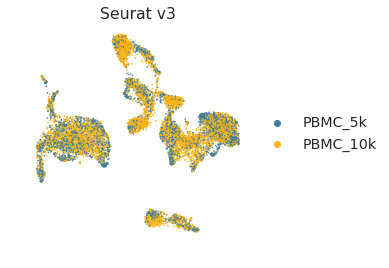

In [30]:
inds = np.random.permutation(np.arange(adata_seurat.X.shape[0]))
fig = sc.pl.umap(adata_seurat[inds], color="Seurat v3", alpha=0.9, return_fig=True, frameon=False)
sns.despine(fig=fig)
fig.savefig("figures/pbmc_seurat_umap.pdf", dpi=DPI, bbox_inches='tight')

## Metrics

In [31]:
totalVI_union_stats = pd.read_csv("/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/misc_results/pbmc_union_stats.csv", index_col=0)
harmo_metrics.loc["totalVI-union"] = totalVI_union_stats.loc["totalVI-union"]

In [32]:
harmo_metrics

,Mixing metric,Hotspot metric,models
totalVI-intersect,-0.0656657,1.98676,totalVI-intersect
totalVI-union,-0.0710488,1.57494,totalVI-union
scanorama,-0.0950904,-2.50788,scanorama
Seurat v3,-0.0475491,-0.299416,Seurat v3


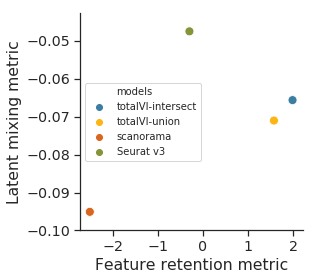

In [33]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.scatterplot(data=harmo_metrics, y="Mixing metric", x="Hotspot metric", hue="models", s=80, ax=ax)
    sns.despine()
    ax.legend(loc="center left", prop={'size': 10}, fancybox=True)
    # ax.set_xlim(0.62, 0.82)
    ax.set_ylabel("Latent mixing metric")
    ax.set_xlabel("Feature retention metric")
    fig.savefig("figures/entropy_vs_retainment_pbmc.pdf", bbox_inches="tight")

In [34]:
from scipy.sparse import vstack
scan_corrected = vstack(corrected).A
corrected

[<6855x4014 sparse matrix of type '<class 'numpy.float32'>'
 	with 27515970 stored elements in Compressed Sparse Row format>,
 <3994x4014 sparse matrix of type '<class 'numpy.float64'>'
 	with 16031916 stored elements in Compressed Sparse Row format>]

In [35]:
denoised_genes, _ = posteriors[-1].sequential().get_normalized_denoised_expression(
    n_samples=50, give_mean=True, transform_batch=[0, 1], 
)
denoised_proteins = posteriors[-1].sequential().get_protein_mean(
    n_samples=50, give_mean=True, transform_batch=[0, 1], 
)

denoised_total = np.concatenate([denoised_genes, denoised_proteins], axis=-1)

In [36]:
from scipy.stats import mannwhitneyu

totalVI_Us = []
totalVI_p_vals = []
scan_Us = []
scan_p_vals = []
mnn_Us = []
mnn_p_vals = []
seurat_Us = []
seurat_p_vals = []
types = []
models = []
full_Us = []
full_ps = []
mannwhit = pd.DataFrame(columns=["Feature", "Mixing metric", "ps", "Method"])
batches = datasets[-1].batch_indices.ravel()
for i in range(denoised_total.shape[1]):
    if i < datasets[2].nb_genes:
        types.append("Gene")
    else:
        types.append("Protein")
    U, p_val = mannwhitneyu(
        denoised_total[batches == 0, i], denoised_total[batches == 1, i]
    )
    totalVI_Us.append(U)
    totalVI_p_vals.append(p_val)
    full_Us.append(U)
    full_ps.append(p_val)
    models.append("totalVI-intersect")
    
    if i < datasets[2].nb_genes:
        types.append("Gene")
    else:
        types.append("Protein")
    
    U, p_val = mannwhitneyu(
        scan_corrected[batches == 0, i], scan_corrected[batches == 1, i]
    )
    scan_Us.append(U)
    scan_p_vals.append(p_val)
    full_Us.append(U)
    full_ps.append(p_val)
    models.append("Scanorama")
    
    if i < datasets[2].nb_genes:
        types.append("Gene")
    else:
        types.append("Protein")
    
    U, p_val = mannwhitneyu(
        adata_seurat.X[batches == 0, i], adata_seurat.X[batches == 1, i]
    )
    seurat_Us.append(U)
    seurat_p_vals.append(p_val)
    full_Us.append(U)
    full_ps.append(p_val)
    models.append("Seurat v3")
    
mannwhit["Feature"] = types
mannwhit["Mixing Metric"] = full_Us
mannwhit["ps"] = full_ps
mannwhit["Method"] = models


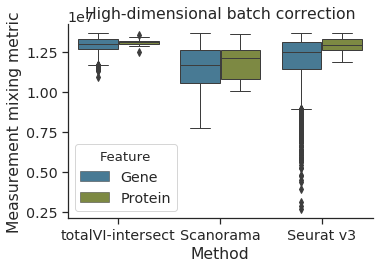

In [37]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(5.5, 4))
    box_colors = ["#3B7EA1", "#859438"]
    sns.boxplot(x="Method", y="Mixing Metric", hue="Feature", data=mannwhit, ax=ax, linewidth=1, palette=box_colors)
    sns.despine()
    ax.set_title("High-dimensional batch correction")
    ax.set_ylabel("Measurement mixing metric")
    plt.tight_layout()
    fig.savefig("figures/pbmc_mann_whitney_u.pdf")